In [181]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import sklearn

In [182]:
### Question 1 ###

In [183]:
# Bullet point 1
def read_im(file):
    return plt.imread(file)

In [184]:
# Bullet point 2
def show_im(data):
    plt.imshow(data)

In [185]:
# Bullet point 3
def get_patch(i, j, h, im):
    i, j, h = int(i), int(j), int(h/2)
    return im[i-h:i+h, j-h:j+h, :]

In [186]:
# Bullet point 4
def patch_to_vect(patch):
    length = np.prod(patch.shape)
    return np.reshape(patch, length)

def vect_to_patch(h, vector):
    h = int(h)
    if 3 * h * h != vector.size: return None
    return np.reshape(vector, (h, h, 3))

In [187]:
# Bullet point 5
def noise(img, prc):
    if prc == 0.0: return img
    shape = img.shape
    px_number = int(img.size/3 * prc)
    to_del = np.random.randint(0, img.size/3, px_number)
    to_del = np.array([np.array([int(x/shape[1]), x%shape[1]]) for x in to_del]).T
    res = img.copy()
    res[to_del[0], to_del[1],:] = np.array([-100,-100,-100])
    return res

def delete_rect(img, i, j, height, width):
    i, j, h, w = int(i), int(j), int(height/2), int(width/2)
    res = img.copy()
    res[i-h:i+h, j-w:j+w, :] = np.array([-100,-100,-100])
    return res

In [188]:
# Bullet point 6
def get_all_patches(img, step, h):
    shape = img.shape
    first_h, last_h = int(h/2), shape[0] - int(h/2)
    first_w, last_w = int(h/2), shape[1] - int(h/2)
    index_h = sorted(list(range(first_h, int(shape[0]/2), 2*step)) + list(range(last_h, int(shape[0]/2), -2*step)))
    index_w = sorted(list(range(first_w, int(shape[1]/2), 2*step)) + list(range(last_w, int(shape[1]/2), -2*step)))
    res = []
    for i in index_h:
        for j in index_w:
            res.append(get_patch(i, j, h, img))
    return np.array(res)

In [189]:
# Bullet point 6
def get_bad_patches(all_patches):
    res = []
    for patch in all_patches:
        if -100 in np.reshape(patch, patch.size): res.append(patch)
    return np.array(res)

In [190]:
# Bullet point 6
def get_dictionnary(all_patches):
    res = []
    for patch in all_patches:
        if not -100 in np.reshape(patch, patch.size): res.append(patch)
    return np.array(res)

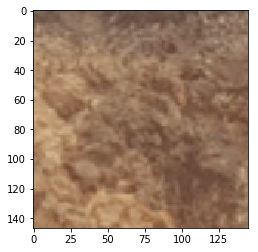

In [191]:
# Load image
desert="../resources/desert.png"
image = read_im(desert)
show_im(image)

In [192]:
# Create a patch, transform and de-transform it into vector
patch = get_patch(100, 100, 10, image)
vector = patch_to_vect(patch)
repatch = vect_to_patch(10, vector)

In [193]:
# Notes : les patchs doivent se recouper, une bonne taille c'est 20px selon le prof

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


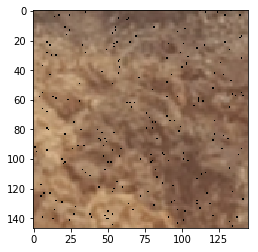

In [194]:
# Put noise on the image
flou = noise(image, 0.01)
rect = delete_rect(image,100,100,10,20)
show_im(flou)

(196, 10, 10, 3)


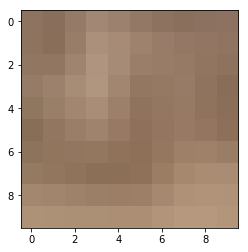

In [195]:
# Get all patches
all_patches = get_all_patches(flou, h=10, step=5)
print(all_patches.shape)
show_im(all_patches[14])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(122, 10, 10, 3)


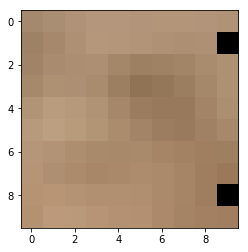

In [196]:
# Get patches with noise
bad_patches = get_bad_patches(all_patches)
print(bad_patches.shape)
show_im(bad_patches[15])

(74, 10, 10, 3)


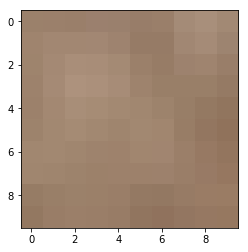

In [197]:
# Get patches without noise
dico = get_dictionnary(all_patches)
print(dico.shape)
show_im(dico[15])

In [198]:
### Question 2 ###

In [199]:
# Removes indexes where pixels are black in patch and in dictionnary + transforms to vectors
def transform_for_lasso(patch_to_pred, dico):
    print(patch_to_pred.shape, dico.shape)
    patch = patch_to_vect(patch_to_pred)
    index = np.argwhere(np.equal(patch, -100))
    patch = np.delete(patch, index)
    patch = np.reshape(patch, (1, patch.size))
    dico = np.array([np.delete(patch_to_vect(p), index) for p in dico])
    dico = np.reshape(dico, (1, dico.shape[0], dico.shape[1]))
    print(patch.shape, dico.shape)
    return patch, dico

In [204]:
# Essai avec un batch flouté quelconque
patch_to_pred = get_bad_patches(all_patches)[15]
patch, dico_learn = transform_for_lasso(patch_to_pred, dico)
# Construct and train lasso
reg_lasso = linear_model.Lasso(alpha = 1.0)
reg_lasso.fit(X=dico_learn, y=patch)

(10, 10, 3) (74, 10, 10, 3)
(1, 294) (1, 74, 294)


ValueError: Found array with dim 3. Estimator expected <= 2.